### 🛠️ Setup and Helper Functions
This cell imports all necessary libraries and defines the global parameters and helper functions. The compute_local_variance function is a key part of the patch selection process, as it helps identify regions with more texture and detail. The script also sets up the output directories and reads the main metadata file.

In [1]:
%matplotlib inline
import os
import json
import math
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# --- Paths ---
source_image_path = "KonJND-1k/source_image"
jpeg_image_path = "KonJND-1k/jpeg"
bpg_image_path = "KonJND-1k/bpg"
patch_image_path = "KonJND-1k/patches"
os.makedirs(patch_image_path, exist_ok=True)

# --- Read metadata CSV ---
metadata_file = pd.read_csv("KonJND-1k/subjective_ratings.csv")

# --- Global Parameters ---
# Patch dimensions
PATCH_SIZE = 20
CENTER_SIZE = 12
OFFSET = (PATCH_SIZE - CENTER_SIZE) // 2
# A threshold to filter out flat, uniform patches
VAR_THRESHOLD = 5.0

# --- Helper: compute local variance ---
def compute_local_variance(img, patch_size):
    """
    Computes the local variance of an image using a sliding window.
    This helps identify textured regions to sample patches from.
    """
    gray = np.array(img.convert("L"), dtype=np.float32)
    kernel = np.ones((patch_size, patch_size), np.float32) / (patch_size**2)
    mean = cv2.filter2D(gray, -1, kernel)
    mean_sq = cv2.filter2D(gray**2, -1, kernel)
    variance = mean_sq - mean**2
    return variance

# Initialize lists to store metadata and metrics
all_patch_metadata = []
all_psnr_values = []

# Precompute 10 bins for balanced sampling
num_bins = 10
bins = np.linspace(0.0, 1.0, num_bins + 1)
bin_counts = [0] * num_bins

# Initialize a random number generator for reproducible results
rng = np.random.default_rng(42)

print("Setup complete. Directories and helper functions are defined.")

Setup complete. Directories and helper functions are defined.


### 🖼️ Patch Generation Loop
This is the main loop that processes each image in the dataset. For each image, it performs the following steps:

1. Select a Rating Level: It determines which distortion level to use to ensure the final dataset has a balanced distribution of scores.

2. Find a Valid Patch: It finds a patch with sufficient local variance to contain meaningful detail, trying multiple locations if necessary.

3. Create Fused Patch: It crops both a clean and a distorted patch, then fuses the distorted center into the clean patch to create the final synthetic sample.

4. Calculate PSNR and Score: It computes the PSNR for the fused patch and normalizes the subjective score from the ratings.

5. Save Patches and Metadata: It saves the clean and fused patches as PNG files and stores all relevant information in a dictionary, which is later saved to a JSON file.

In [2]:
# --- Iterate over each entry in the metadata file ---
for int_idx, (_, row) in enumerate(metadata_file.iterrows()):
    img_id = row["image_id"]
    img_id_base = os.path.splitext(img_id)[0]
    comp_type = row["Compression type"]
    ratings = json.loads(row["ratings"])

    # Load the source (clean) image
    source_image_file = os.path.join(source_image_path, img_id)
    source_image = Image.open(source_image_file).convert("RGB")

    # Compute variance map to find textured regions
    variance_map = compute_local_variance(source_image, PATCH_SIZE)
    candidate_coords = np.argwhere(variance_map >= VAR_THRESHOLD)
    if len(candidate_coords) == 0:
        # If no textured regions found, sample from the entire image
        candidate_coords = np.argwhere(np.ones_like(variance_map))

    # Normalize subjective ratings to a [0, 1] scale
    max_rating_value = 100 if comp_type == "JPEG" else 53
    grades = np.zeros(max_rating_value + 1, dtype=float)
    for r in ratings:
        grades[r + 1 :] += 1
    if grades.max() > 0:
        grades /= grades.max()

    # Find the target score bin with the fewest samples to ensure balance
    target_bin = int(np.argmin(bin_counts))
    target_value = (bins[target_bin] + bins[target_bin + 1]) / 2

    # Select the distortion level closest to the target score
    level_idx = np.argmin(np.abs(grades - target_value))

    # Try to generate a valid patch
    max_attempts = 20
    for attempt in range(max_attempts):
        # Sample one patch location weighted by the variance
        flat_var = variance_map.flatten()[
            [y * variance_map.shape[1] + x for y, x in candidate_coords]
        ]
        prob = flat_var / flat_var.sum()
        selected_idx = rng.choice(len(candidate_coords), p=prob)
        y, x = candidate_coords[selected_idx]
        x = min(x, source_image.width - PATCH_SIZE)
        y = min(y, source_image.height - PATCH_SIZE)
        patch_region = (x, y, x + PATCH_SIZE, y + PATCH_SIZE)

        # Load the corresponding distorted image
        if comp_type == "JPEG":
            distorted_filename = f"{img_id_base}_JPEG_0{level_idx:02d}.jpg"
            distorted_image_file = os.path.join(jpeg_image_path, distorted_filename)
        else:
            distorted_filename = f"{img_id_base}_BPG_0{level_idx:02d}.png"
            distorted_image_file = os.path.join(bpg_image_path, distorted_filename)
        
        if not os.path.exists(distorted_image_file):
            continue
        distorted_image = Image.open(distorted_image_file).convert("RGB")

        # Extract and fuse the patches
        clean_patch = source_image.crop(patch_region)
        distorted_patch = distorted_image.crop(patch_region)
        center_box = (OFFSET, OFFSET, OFFSET + CENTER_SIZE, OFFSET + CENTER_SIZE)
        distorted_center = distorted_patch.crop(center_box)
        fused_patch = clean_patch.copy()
        fused_patch.paste(distorted_center, center_box)

        # Check for zero MSE (identical images)
        np_clean = np.array(clean_patch).astype(np.float64)
        np_fused = np.array(fused_patch).astype(np.float64)
        mse = np.mean((np_clean - np_fused) ** 2)

        if mse == 0:
            continue

        # Compute PSNR and score, then save
        psnr_value = 10 * math.log10(255**2 / mse)
        patch_score = float(grades[level_idx])

        clean_patch_filename = f"{img_id_base}_patch_{int_idx}_clean.png"
        fused_patch_filename = f"{img_id_base}_patch_{int_idx}_fused.png"
        clean_patch.save(os.path.join(patch_image_path, clean_patch_filename), "PNG")
        fused_patch.save(os.path.join(patch_image_path, fused_patch_filename), "PNG")

        # Store metadata
        patch_entry = {
            "unique_sample_id": f"{img_id_base}_{int_idx}",
            "clean_image": clean_patch_filename,
            "distorted_image": fused_patch_filename,
            "score": patch_score,
            "metadata": {
                "image_id": img_id,
                "compression_type": comp_type,
                "ratings": [int(r) for r in ratings],
                "region": [int(v) for v in patch_region],
                "method": "hybrid_sampling_balanced10",
                "psnr": psnr_value,
            },
        }
        all_patch_metadata.append(patch_entry)
        all_psnr_values.append(psnr_value)

        # Update bin count and break the attempt loop
        bin_counts[target_bin] += 1
        break

print("Finished generating and saving patches and metadata.")

Finished generating and saving patches and metadata.


### 📊 Finalization and Visualization
This final cell saves the collected metadata and generates two plots to visualize the dataset. The PSNR histogram shows the distribution of PSNR values for the synthetic patches, while the scatter plot visualizes the relationship between the PSNR and the subjective score, which is a key metric for this type of dataset.

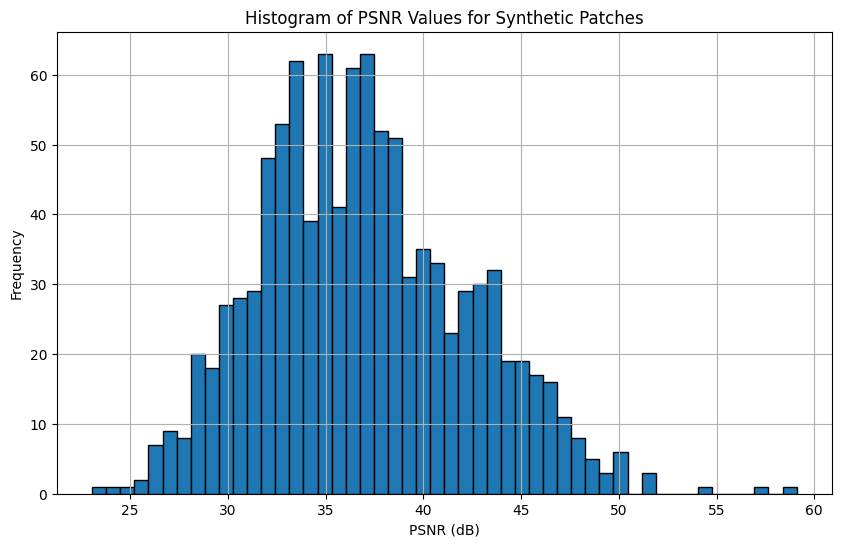

PSNR histogram saved and displayed.


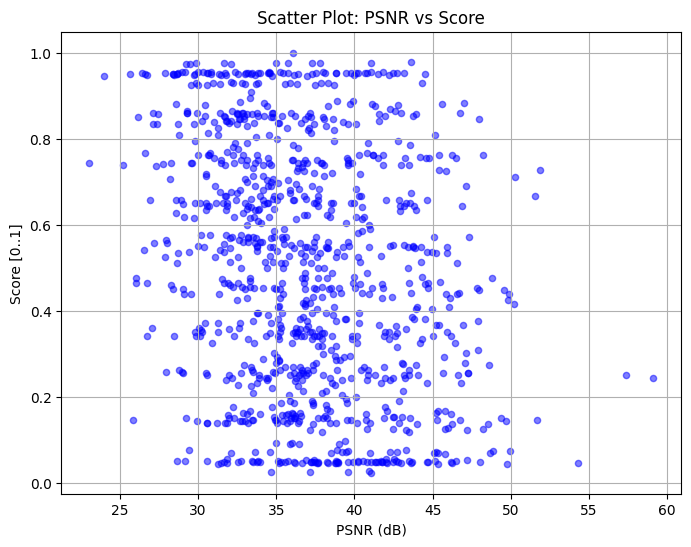

PSNR vs Score scatter plot saved and displayed.

--- Summary ---
Patch creation done. Total patches: 1007
Final bin counts: [101, 101, 101, 101, 101, 101, 101, 100, 100, 100]
Metadata saved to: KonJND-1k/patches\metadata.json


In [3]:
# --- Save the collected metadata to a JSON file ---
output_json_path = os.path.join(patch_image_path, "metadata.json")
with open(output_json_path, "w") as f:
    json.dump(all_patch_metadata, f, indent=4)

# --- PSNR Histogram ---
plt.figure(figsize=(10, 6))
plt.hist(all_psnr_values, bins=50, edgecolor="black")
plt.title("Histogram of PSNR Values for Synthetic Patches")
plt.xlabel("PSNR (dB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(os.path.join(patch_image_path, "psnr_histogram.png"))
plt.show()   # 👈 show inline
print("PSNR histogram saved and displayed.")


# --- Scatter plot of PSNR vs Score ---
scores = [entry["score"] for entry in all_patch_metadata]
psnrs = [entry["metadata"]["psnr"] for entry in all_patch_metadata]

plt.figure(figsize=(8, 6))
plt.scatter(psnrs, scores, alpha=0.5, s=20, c="blue")
plt.xlabel("PSNR (dB)")
plt.ylabel("Score [0..1]")
plt.title("Scatter Plot: PSNR vs Score")
plt.grid(True)
plt.savefig(os.path.join(patch_image_path, "psnr_vs_score.png"))
plt.show()   # 👈 show inline
print("PSNR vs Score scatter plot saved and displayed.")


print("\n--- Summary ---")
print(f"Patch creation done. Total patches: {len(all_patch_metadata)}")
print(f"Final bin counts: {bin_counts}")
print(f"Metadata saved to: {output_json_path}")
